# Linear regression 

In this exercise you will use linear regression to predict flat prices. Training will be handled via gradient descent and we will:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a non-standard loss function.

Let's start with getting the data.

In [1]:
%matplotlib inline

!wget -O dataset/mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O dataset/mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

--2022-10-27 14:58:09--  https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6022:18::a27d:4212, 162.125.66.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/zey0gx91pna8irj/mieszkania.csv [following]
--2022-10-27 14:58:09--  https://www.dropbox.com/s/dl/zey0gx91pna8irj/mieszkania.csv
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1e4aecd0d8a9853a2517141660.dl.dropboxusercontent.com/cd/0/get/Bvmx1BLLkKZs_HhAxaE1OWLdnDmSaArzFR3yQIgV_bJPIJ9UDnNhPG2oqh7osnO69meIqkEMAAzEHl4pLO3fEfapEp6vDnn73dsFFobi06C0PUkVrVxKDc7dbb8Jp5mjixKfmmBCgWpfWloGDv0wFXc_jRJGFCUtDbSwEWtVBHAKyQ/file?dl=1# [following]
--2022-10-27 14:58:10--  https://uc1e4aecd0d8a9853a2517141660.dl.dropboxusercontent.com/cd/

In [2]:
!head dataset/mieszkania.csv dataset/mieszkania_test.csv

==> dataset/mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> dataset/mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
71,wolowo,2,2,1912,1,322227
45,mokotowo,1,1,1938,0,295878
38,mokotowo,1,1,1999,1,306530
70,ochotowo,2,2,1980,1,553641
136,mokotowo,3,2,1939,1,985348
128,wolowo,3,2,1983,1,695726
23,grodziskowo,1,1,1975,0,99751
117,mokotowo,3,2,1942,0,891261
65,ochotowo,2,1,2002,1,536499


In [3]:
### Prepare data ###
import pandas
import numpy

# Open the data from csv and create dummy rows

train_data_without_dummies = pandas.read_csv('dataset/mieszkania.csv')
test_data_without_dummies = pandas.read_csv('dataset/mieszkania_test.csv')

train_data = pandas.get_dummies(train_data_without_dummies, prefix='dzielnica')
test_data = pandas.get_dummies(test_data_without_dummies, prefix='dzielnica')

total = pandas.concat([train_data, test_data])

Each row in the data represents a separate property. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a property's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,ilosc_lazienek,rok_budowy,parking_podziemny`). 

From now on, we should interfere only with `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

Our predictions should minimize the so-called mean squared logarithmic error:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's start with implementing the loss function.

In [4]:
### Mean squared logarithmic error ###

def msle(ys, ps):
    assert len(ys) == len(ps)
    msle_sum = 0
    
    for i in range(len(ys)):
      yi = ys[i]
      pi = ps[i]

      msle_sum = msle_sum + (numpy.log(1+yi) - numpy.log(1+pi)) ** 2
    return msle_sum / len(ys)

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [5]:
### Msle for outputing the mean price ###

n = len(train_data["cena"])

### Mean price
train_mean = numpy.mean(train_data["cena"])
print("Mean price of a flat from the training dataset: ", train_mean)

### MSLE for train set
trainset_msle = msle(train_data["cena"], [train_mean] * n)
print("MSLE for the train set is: ", trainset_msle)

### MSLE for test set
testset_msle = msle(test_data["cena"], [train_mean] * n)
print("MSLE for the test set is: ", testset_msle)


Mean price of a flat from the training dataset:  507919.49
MSLE for the train set is:  0.3915253538257009
MSLE for the test set is:  0.4284115392580848


Recall that outputing the mean minimzes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

In [6]:
### Minimalizing MSLE ###

# On paper - calculate the derivative of MSLE, check where it has a 0.
# const p = exp ((sum (log 1 + y_i)) / n) - 1
# TODO: add photo here from the class

sum = 0
for i in range(n):
  sum = sum + numpy.log(1 + train_data["cena"][i])

minimizing_msle = numpy.exp(sum/n) - 1

print("Minimizing value from calculating the derivative: ", minimizing_msle)

trainset_msle_derrivative = msle(train_data["cena"], [minimizing_msle] * n)
testset_msle_derrivative = msle(test_data["cena"], [minimizing_msle] * n)

print("MSLE for the train set & derivative is: ", trainset_msle_derrivative)
print("MSLE for the test set & derivative is: ", testset_msle_derrivative)

Minimizing value from calculating the derivative:  431435.49158234044
MSLE for the train set & derivative is:  0.3648896122133587
MSLE for the test set & derivative is:  0.42757520337601745


Now, let's implement a standard linear regression model.

In [7]:
# Implement MSE

def mse(ys, ps):
    assert len(ys) == len(ps)
    mse_sum = 0

    for i in range(len(ys)):
        yi = ys[i]
        pi = ps[i]

        mse_sum = mse_sum + (yi - pi) ** 2
    return mse_sum / len(ys)

In [8]:
def mae(ys, ps):
    assert len(ys) == len(ps)
    mae_sum = 0

    for i in range(len(ys)):
        yi = ys[i]
        pi = ps[i]
        mae_sum += abs(yi - pi)

    return mae_sum / len(ys)

In [9]:
from matplotlib import pyplot
# Linear regression

class LinearRegression:
    def __init__(self, learning_rate, weight_number, epochs_number):
        self.learning_rate = learning_rate
        self.weight_number = weight_number
        self.epoch_numbers = epochs_number
        self.loss_values = []

    def plot_loss(self, title):
        pyplot.plot(self.loss_values)
        pyplot.title(title)
        pyplot.xlabel("Epoch number")
        pyplot.ylabel("Loss value")
        pyplot.show()


    def train(self, train_dataset, train_groundtruth):
        self.loss_values = []
        weights = numpy.random.normal(size=train_dataset.shape[1])

        for e in range(self.epoch_numbers):
            predict_price = numpy.dot(train_dataset, weights)
            current_mse = mse(train_groundtruth, predict_price)
            gradient = (2/self.weight_number) * numpy.dot (train_dataset.T, predict_price - train_groundtruth)
            weights -= self.learning_rate * gradient

            self.loss_values.append(current_mse)

        return weights

In [10]:
# Split datasets
train_data_y = train_data['cena'].to_numpy()
train_data_x = train_data.drop('cena', axis=1).to_numpy()

test_data_y = test_data['cena'].to_numpy()
test_data_x = test_data.drop('cena', axis=1).to_numpy()

# Standardization of datasets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data_x)
test_x_scaled = scaler.transform(test_data_x)
train_x_scaled = scaler.transform(train_data_x)

# Adding bias
test_x_scaled = numpy.hstack((numpy.ones_like(test_x_scaled), test_x_scaled))
train_x_scaled = numpy.hstack((numpy.ones_like(train_x_scaled), train_x_scaled))


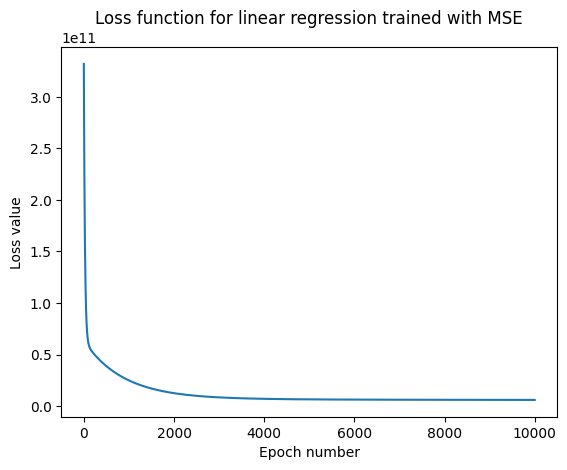

MSLE for linear regression trained with MSE:  0.05486051964713914
MAE for linear regression traines with MSE:  60718.9100396652  (which means - usually we are wrong by this)


In [13]:
# Train regular linear regression

linear_regression = LinearRegression(0.001, len(train_x_scaled), 10000)
model_weights = linear_regression.train(train_x_scaled, train_data_y)
linear_regression.plot_loss("Loss function for linear regression trained with MSE")

# Test the model against MSLE
test_results = numpy.dot(test_x_scaled, model_weights)
print('MSLE for linear regression trained with MSE: ', msle(test_data_y, test_results))
print("MAE for linear regression traines with MSE: ", mae(test_data_y, test_results), " (which means - usually we are wrong by this)")

Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint:
Be lazy. We don't want to change the algorithm.

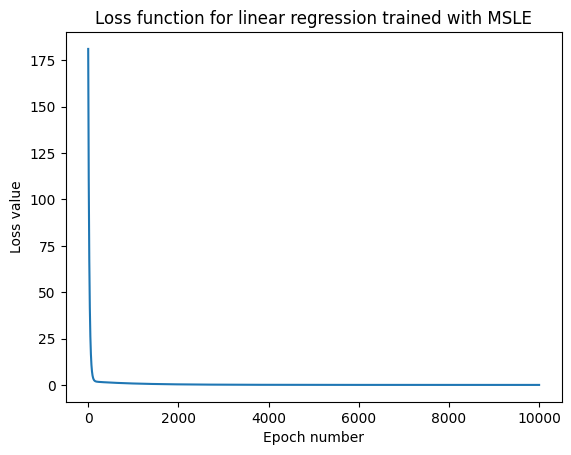

MSLE for linear regression trained with MSLE:  0.06903363025914383
MAE for linear regression traines with MSLE:  86507.62220322076  (which means - usually we are wrong by this)


In [14]:
# Train linear regression to optimize MSLE #

model_weights_with_msle = linear_regression.train(train_x_scaled, numpy.log(train_data_y + 1))
linear_regression.plot_loss("Loss function for linear regression trained with MSLE")

# Test the model against MSLE
test_results_with_msle = numpy.expm1(numpy.dot(test_x_scaled, model_weights_with_msle))
print('MSLE for linear regression trained with MSLE: ', msle(test_data_y, test_results_with_msle))
print("MAE for linear regression traines with MSLE: ", mae(test_data_y, test_results_with_msle), " (which means - usually we are wrong by this)")


Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code. 

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

Hint: 
Is having a binary encoding for each district and multiplying it by area enough?

Hint 2: 
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).

In [40]:
from itertools import permutations

# Multiply each row by another row and add as new features

# Add features to scaled test

test_data_x_features = test_data
train_data_x_features = train_data

train_data_x_features = pandas.get_dummies(train_data_x_features, prefix='dzielnica')
test_data_x_features = pandas.get_dummies(test_data_x_features, prefix='dzielnica')

cols = list(train_data_x_features.columns)
cols.remove('cena')

def duplicate_features(table):
    for x, y in permutations(table.keys(), 2):
        table[x+"x"+y] = table[x] * table[y]
    return table

train_data_x_features = duplicate_features(train_data_x_features[cols]).to_numpy()
test_data_x_features = duplicate_features(test_data_x_features[cols]).to_numpy()

train_data_x_features = numpy.hstack((numpy.ones_like(train_data_x_features), train_data_x_features))
test_data_x_features = numpy.hstack((numpy.ones_like(test_data_x_features), test_data_x_features))

# Scale data
new_scaler = MinMaxScaler()
new_scaler.fit(train_data_x_features)
train_data_x_features_scaled = new_scaler.transform(train_data_x_features)
test_data_x_features_scaled = new_scaler.transform(test_data_x_features)

# Add bias
test_data_x_features_scaled = numpy.hstack((numpy.ones_like(test_data_x_features_scaled), test_data_x_features_scaled))
train_data_x_features_scaled = numpy.hstack((numpy.ones_like(train_data_x_features_scaled), train_data_x_features_scaled))

# test_data_x_features_scaled
# train_data_x_features_scaled

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

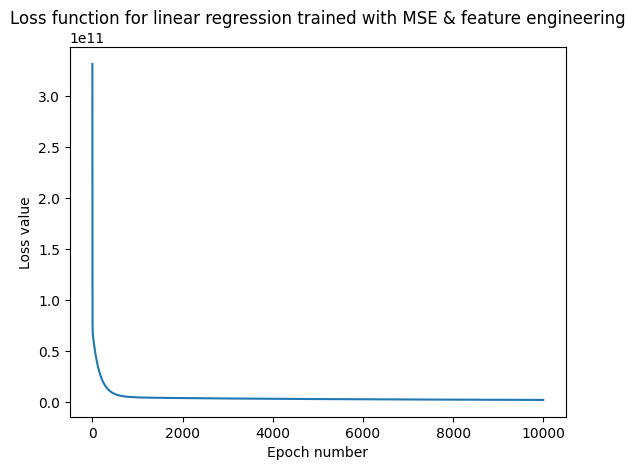

MSLE for linear regression trained with MSE & feature engineering:  0.023756334556309065
MAE for linear regression traines with MSE & feature engineering  36014.359172853496  (which means - usually we are wrong by this)


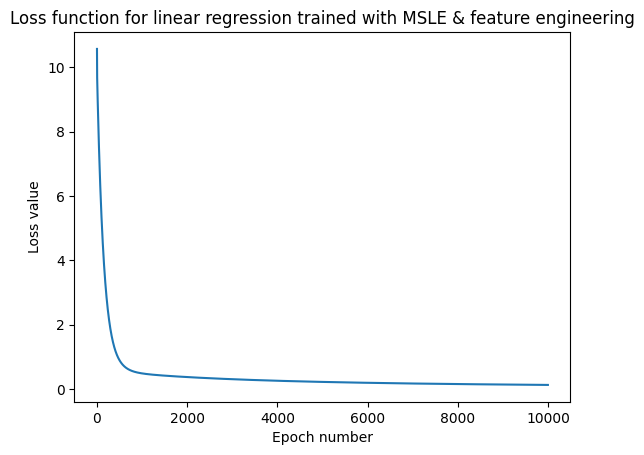

MSLE for linear regression trained with MSLE & feature eigineering:  0.12531365886993326
MAE for linear regression traines with MSLE & feature engineering:  131062.68044639232  (which means - usually we are wrong by this)


In [45]:
# Test solution on the training and test datasets #

# Train regular linear regression

linear_regression = LinearRegression(0.001, len(train_data_x_features_scaled), 10000)
model_weights_features = linear_regression.train(train_data_x_features_scaled, train_data_y)
linear_regression.plot_loss("Loss function for linear regression trained with MSE & feature engineering")

# Test the model against MSLE
test_features_results =  numpy.dot(test_data_x_features_scaled, model_weights_features)
print('MSLE for linear regression trained with MSE & feature engineering: ', msle(test_data_y, test_features_results))
print("MAE for linear regression traines with MSE & feature engineering ", mae(test_data_y, test_features_results), " (which means - usually we are wrong by this)")

# Train linear regression with MSLE

linear_regression = LinearRegression(0.001, len(train_data_x_features_scaled), 10000)
model_weights_features = linear_regression.train(train_data_x_features_scaled, numpy.log(train_data_y + 1))
linear_regression.plot_loss("Loss function for linear regression trained with MSLE & feature engineering")

# Test the model against MSLE
test_features_results =  numpy.expm1(numpy.dot(test_data_x_features_scaled, model_weights_features))
print('MSLE for linear regression trained with MSLE & feature eigineering: ', msle(test_data_y, test_features_results))
print("MAE for linear regression traines with MSLE & feature engineering: ", mae(test_data_y, test_features_results), " (which means - usually we are wrong by this)")